# Real Life Linear Models

Now we've shown we can fit some model to data, let's try a real world example, with real astronomy data. For our real data, let's grab some time series. Here I'll use time series from the Kepler mission, because it's easy to access and pretty easy to understand.


<div class="admonition caution">
<p class="admonition-title">So far, we're not including uncertainties.</p>
    <p>In the previous section we derived Ordinary Least Squares. For now, we've only derived a way to fit a proposed <b>linear model</b> to data, but we haven't figured out how to include errors on the data. We'll come to that soon. </p>
</div>


In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

In [19]:
lc = lk.search_lightcurve('Kepler-10', 
                          mission='Kepler', 
                          quarter=10, 
                          exptime=1800).download()

Above, I've downloaded data for the target "Kepler-10", which is a famous star from the Kepler mission. This star has a planet transiting around it. The time-series data here is just the brightness of the target over time. We can grab the data out of this Python object. I will use only the first 1000 elements as an example.


<div class="admonition">
<p class="admonition-title">Lightkurve Objects</p>
    <p><code>lc</code> is a <code>lightkurve</code> object, which you might already know how to work with, and has lots of helpful functions. However, for the purposes of this tutorial, I'm just going to take the time and flux components from this object and work with them as <code>numpy</code> arrays directly. </p>
</div>

In [20]:
x, y = (lc.remove_nans().time.value[:1000],
        np.asarray(lc.remove_nans().normalize().flux.value)[:1000])
x -= x.mean()

In [21]:
x[:5]

array([-10.33453882, -10.31410481, -10.29367069, -10.27323678,
       -10.25280277])

In [22]:
y[:5]

array([1.0002722, 1.0003943, 1.0003676, 1.0004128, 1.0004009],
      dtype=float32)

Now we have the array of times `x` and the array of flux values `y`. Let's plot them below.

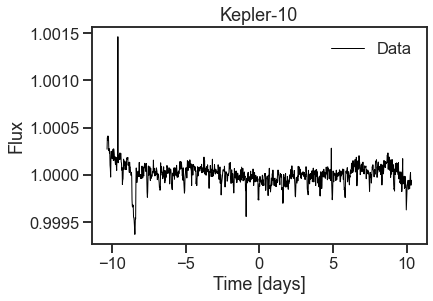

In [23]:
fig, ax = plt.subplots()
ax.plot(x, y, lw=1, label='Data', c='k')
ax.set(xlabel='Time [days]', ylabel='Flux', title='Kepler-10')
ax.legend()

Great. In the above data, we can see lots going on. Firstly we see that there is a large dip in flux around time -11. This is because a planet has transited the star, blocking some of the light, and reducing the flux. We also see that there is a repeating signal where the flux drops sharply every ~0.7 days. This is a second planet in the system!

We also see that there is some sort of long term trend in the data.

Let's assume here that we're trying to remove the long term trend, so we can learn more about those transits.

**Let's build ourselves a linear model!**

We'll start simple. We're going to use another **polynomial**. We're trying to fit time series, so we want a model that is a **polynomial in time**. 

Let's start there.

Step one. We're going to need a **design matrix**. We know we want our model to take the form of:

$\mathbf{y} = w_0*\mathbf{t}^0 + w_1*\mathbf{t}^1 + w_2*\mathbf{t}^2$

i.e. 

$\mathbf{y} = w_0 + w_1*\mathbf{t} + w_2*\mathbf{t}^2$

Where $\mathbf{t}$ is a vector of times, and $w_0$, $w_1$ and $w_2$ are single valued elements of a vector of weights $\mathbf{w}$.

We can write this as

$\mathbf{y} = \mathbf{A} \cdot \mathbf{w}$

where $\mathbf{A}$ is a design matrix made up of the column vectors $\mathbf{t}^0, \mathbf{t}^1, \mathbf{t}^2$ and $\mathbf{w}$ is a vector with three elements (i.e. the weights).

Let's build that matrix.

In [27]:
A = np.vstack([x ** idx for idx in range(3)]).T

In [28]:
A

array([[  1.        , -10.33453882, 106.80269269],
       [  1.        , -10.31410481, 106.38075801],
       [  1.        , -10.29367069, 105.95965637],
       ...,
       [  1.        ,  10.28330221, 105.7463043 ],
       [  1.        ,  10.30373605, 106.16697658],
       [  1.        ,  10.32416999, 106.588486  ]])

Above we've made the columns vector $\mathbf{t}^0, \mathbf{t}^1, \mathbf{t}^2$ and used `vstack` and the transpose operation to turn them into a tall design matrix with shape

In [29]:
A.shape

(1000, 3)


<div class="admonition tip">
<p class="admonition-title">Whitening vectors</p>
    <p>Above you'll see that I have taken the vector <b>x</b> and taken it to powers of 0, 1, and 2. And you will also see that I have removed the mean value from the  <b>x</b> vector when I loaded the data, so that the mean is 0.</p>
 <p>In most cases, if we can, we ideally want to "whiten" the vectors we are using. Whitenined here means making the vectors have mean 0, and ideally standard deviation of 1.</p>
    
    
    <p>If I were trying to do a 20th order polynomial in <b>x</b>, and I was trying to do  <b>x</b>^20 I might find:</p>

    <p>1. For large positive or negative numbers, I might struggle with machine precision</p>
<p>2. When trying to fit linear models with vectors that have extremely large (e.g. 1e100) or extremely small values (e.g. 1e-100) machine precision problems will compound and I can get odd answers.</p>


<p>Because of this, if I'm building a design matrix like the one above, it's good practice to "whiten" the vectors before hand. I could do that here by removing the mean from <b>x</b> and dividing through by the standard deviation before taking each power.</p>
    
<p>In this instance, I'm not going to do this, because it will make things more legible, and because I already know for these vectors contain small numbers, even if I take them to large power. But, if you're having problems in your own model, it won't hurt to take a look at the values that are in A, and see if you're trying to fit a matrix that has a lot of very large and/or very small values.</p>

</div>


Now we have our design matrix $\mathbf{A}$ and we have our data $\mathbf{y}$, we just need to fit to find the best fitting weights $\mathbf{w}$. That's easy now we've derived our OLS equation above:

In [33]:
w = np.linalg.solve(A.T.dot(A), A.T.dot(y))
w

array([ 9.99974089e-01, -2.69034712e-06,  9.58978925e-07])

Easy! Let's take a look at the model. Remember to get the best fitting model we can now just take the dot product of our design matrix with our weights:
$\mathbf{A}\cdot\mathbf{w}$

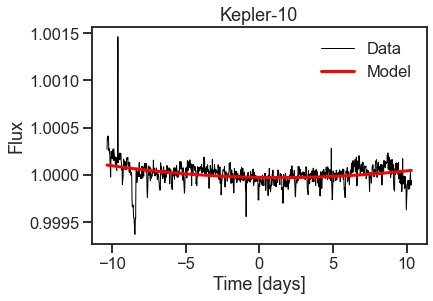

In [34]:
fig, ax = plt.subplots()
ax.plot(x, y, lw=1, label='Data', c='k')
ax.plot(x, A.dot(w), lw=3, label='Model', c='r')
ax.set(xlabel='Time [days]', ylabel='Flux', title='Kepler-10')
ax.legend()

Looks great! We've got a model that fits our data, and it looks fairly accurate! It's capturing the high level trend of the data.

However, we've built a very simple model. In this model, there's not the flexibility we need to capture finer detail. How can we improve that? Here are some ideas.

### Idea 1: We could increase the complexity of the model

This is done easily, we could increase the polynomial order of the model to try to capture more of the variability. Let's do that quickly:

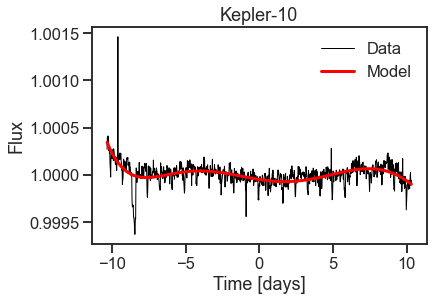

In [35]:
# 7th order polynomial
A = np.vstack([(x) ** idx for idx in range(7)]).T
w = np.linalg.solve(A.T.dot(A), A.T.dot(y))

fig, ax = plt.subplots()
ax.plot(x, y, lw=1, label='Data', c='k')
ax.plot(x, A.dot(w), lw=3, label='Model', c='r')
ax.set(xlabel='Time [days]', ylabel='Flux', title='Kepler-10')
ax.legend()

Ok! A more complex polynomial is a better fit!

This is ok, and we're not taking the polynomial order very high, but let's just think critically for a second about what we're doing here...

Here we have set up a model that says "at any point in time, I can predict the flux of the star from just these weights $\mathbf{w}$." Do we think it's likely that these same weights hold for all times? For 1st or 2nd order polynomial orders, that might be fairly true; if the star has a brightness around 1 now, it'll probably have a brightness around 1 at any time.

But as we increase the polynomial order too high, our prediction for other times probably explodes quickly...Let's check. Let's make up some other times, and see what our model predicts.

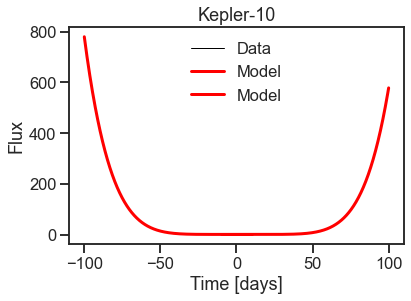

In [36]:
# 7th order polynomial
x2 = np.linspace(-100, 100, 1000)
A2 = np.vstack([(x2) ** idx for idx in range(7)]).T

fig, ax = plt.subplots()
ax.plot(x, y, lw=1, label='Data', c='k')
ax.plot(x, A.dot(w), lw=3, label='Model', c='r')
ax.plot(x2, A2.dot(w), lw=3, label='Model', c='r')
ax.set(xlabel='Time [days]', ylabel='Flux', title='Kepler-10')
ax.legend()

Hmm. This model has blown up pretty quickly on either side of our data. Looking at this as scientists, we already know this isn't correct. The underlying physical process probably **isn't** well described by a 7th order polynomial, because astrophysically this target is not likely to increase in brightness by factors of 100 over a few days. 

It is, however, a convenient and easy model. You might want to use such a model often, to capture for example some nuisance trend in your data in a way that's easy to write down and fit. There are cases where it's safe to do this! In this case, we're doing it to remove stellar variability so we can see transits. However, you should always keep in mind the limitations of your model, and in this case, the limitation is that it is not likely to be a good predictive model far from the data range, and it's probably not well describing the astrophysics, it's just convenient.

### Idea 2: We could change the model

Instead of making this a polynomial, which is probably not a very accurate representation of the data, we could instead build a different model. Let's try doing something like that, and let's draw from our astrophysics background.

We know this is a star, and we know stars rotate, and can have periodic behavior. Let's propose a sinusoid is a good fit for the data.

Take a look at the below model 

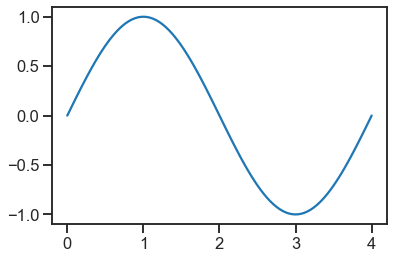

In [37]:
x = np.linspace(0, 4, 100)
period = 4
plt.plot(x, np.sin(x * (2 * np.pi)/period))

Above is the curve $sin(\frac{2x\pi}{P})$ where $P$ is the period of the curve. If we want to make a model where **$P$ is a variable** in our model, this **cannot be a linear model** because it is inside the $sin$ function. There is no way for us to tune the period $P$ in this model by multiplying by a coefficient.

Multiplying by a coefficient will only change the amplitude of the curve:

$w_0 sin(\frac{2x\pi}{P})$

So what do we do? In a case where we happen to know a period, we can use a linear model to find the best fitting amplitude of the sinusoid, but we can't use a linear model to find the best fitting period.

For now, we're going to say this isn't a good model to achieve what we want, but we'll address this in a different notebook on Periodograms.

### Idea 3: What if we could use a piecewise polynomial

### Idea 4: There must be a better way.

There actually is a better way than this, but to get to that point we're going to have to go back to the drawing board, and we're going to have start understanding **errors**. We'll get into that soon.

<div class="admonition">
<p class="admonition-title">The Take Aways</p>
    <p> In this notebook you should have seen that <ul>
    <li>1)  </li>
    <li>2)  </li>
    <li>3)  </li></ul></p>
</div>